# Bild Klassifikation mit TensorFLow
# 🐶🐱 Dogs vs. Cats Classifier mit CNN, Data Augmentation und Transfer Learning

In diesem Projekt wird ein Convolutional Neural Network (CNN) trainiert, um Bilder von Hunden und Katzen zu klassifizieren. Dabei werden moderne Techniken wie **Data Augmentation**, **Transfer Learning (VGG16)** und **Fine Tuning** eingesetzt und verglichen, um die Modellgenauigkeit zu verbessern.




## 📦 Datenaufbereitung
  
Die Bilddaten stammen aus der Kaggle-Competition **"Dogs vs. Cats"** und umfassen insgesamt **25.000 Bilder** – je zur Hälfte Hunde und Katzen.

🎯 Ziel dieses Abschnitts ist es, den Datensatz automatisiert über die **Kaggle API** herunterzuladen, zu entpacken, zu analysieren und optimal für das spätere Modelltraining vorzubereiten.

Zunächst werden alle benötigten Bibliotheken geladen. 📚 Danach erfolgt der Download des Datasets über die offizielle Kaggle API, gefolgt vom Entpacken der ZIP-Dateien.

📄 Anschließend wird ein **DataFrame** erstellt, der die Bilddateien mit ihren zugehörigen Labels verbindet (`0 = Katze`, `1 = Hund`).  
Diese Daten werden dann in **Trainings-, Validierungs- und Testdaten** aufgeteilt – im Verhältnis **70 % / 15 % / 15 %**.

Um das spätere Einlesen mit TensorFlow zu erleichtern, werden alle Bilder automatisch in eine klare Ordnerstruktur verschoben:
- `/train/cats` und `/train/dogs`
- `/validation/cats` und `/validation/dogs`
- `/test/cats` und `/test/dogs`

📊 Nach der erfolgreichen Aufteilung wird die Anzahl der Bilder je Klasse gezählt. Zum Abschluss wird eine kleine **Vorschau zufälliger Bilder** angezeigt, damit du ein Gefühl für den Datensatz bekommst – inklusive der richtigen Klassenzuordnung.


In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip -d dogs_vs_cats_data

Archive:  dogs-vs-cats.zip
  inflating: dogs_vs_cats_data/sampleSubmission.csv  
  inflating: dogs_vs_cats_data/test1.zip  
  inflating: dogs_vs_cats_data/train.zip  


In [ ]:
!unzip -q "dogs_vs_cats_data/train.zip"

In [ ]:
#!unzip -q "dogs_vs_cats_data/test1.zip"

In [ ]:
def prepare_data(train_path, val_size=0.15, test_size=0.15, random_state=42):

    train_filenames = os.listdir(train_path)
    train_categories = [1 if filename.split(".")[0] == 'dog' else 0 for filename in train_filenames]

    df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })


    train_df, temp_df = train_test_split(df, test_size=(val_size + test_size), stratify=df["category"], random_state=random_state)

    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_ratio), stratify=temp_df["category"], random_state=random_state)

    return train_df, val_df, test_df

In [ ]:
train_path = "/content/train"
train_df, val_df, test_df = prepare_data(train_path)

In [ ]:
train_df.head()

,filename,category
23824,dog.9397.jpg,1
21786,cat.6397.jpg,0
7920,dog.8190.jpg,1
13110,cat.4688.jpg,0
409,dog.5764.jpg,1


In [ ]:
val_df.head()

,filename,category
1173,dog.4459.jpg,1
19795,cat.483.jpg,0
20615,cat.11227.jpg,0
6530,cat.1398.jpg,0
13089,dog.8240.jpg,1


In [ ]:
test_df.head()

,filename,category
21967,dog.9725.jpg,1
19829,cat.10517.jpg,0
24556,dog.4633.jpg,1
4459,cat.11188.jpg,0
13599,dog.1123.jpg,1


In [ ]:
def subsampled_dataset(df, source_path, base_dir, dataset_type):
    dogs_dir = os.path.join(base_dir, dataset_type, "dogs")
    cats_dir = os.path.join(base_dir, dataset_type, "cats")
    os.makedirs(dogs_dir, exist_ok=True)
    os.makedirs(cats_dir, exist_ok=True)
    source_path = Path(source_path)

    for category, num, folder in [("cat", 0, cats_dir), ("dog", 1, dogs_dir)]:
        for i, filename in enumerate(df[df["category"] == num]["filename"]):
            src = source_path / filename
            dst = os.path.join(folder, f"{category}{i}.jpg")
            shutil.copyfile(src, dst)

In [ ]:
base_dir = "cats_vs_dogs"
subsampled_dataset(train_df, train_path, base_dir, "train")

In [ ]:
subsampled_dataset(val_df, train_path, base_dir, "validation")

In [ ]:
subsampled_dataset(test_df, train_path, base_dir, "test")

In [ ]:
cats = len(os.listdir("cats_vs_dogs/train/cats"))
dogs = len(os.listdir("cats_vs_dogs/train/dogs"))

In [ ]:
def display_images(df, image_path, num_images=6):

    sample_data = df.sample(n=num_images).reset_index(drop=True)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        filename = sample_data.loc[i, "filename"]
        img = Image.open(os.path.join(image_path, filename))

        img = img.resize((128, 128))

        label = "Dog" if sample_data.loc[i, "category"] == 1 else "Cat"

        ax.imshow(img)
        ax.set_title(label, fontsize=20)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

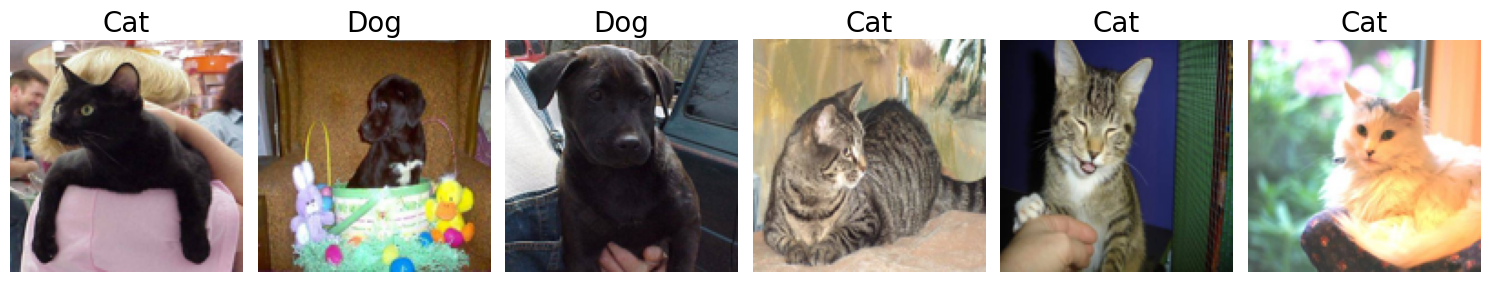

In [ ]:
display_images(train_df, train_path)

## 🧠 Modellarchitektur & Training

Nachdem die Bilddaten erfolgreich vorbereitet und in strukturierte Ordner verschoben wurden, geht es nun an das Einlesen der Bilder und den Aufbau des neuronalen Netzes.

Zuerst werden die Bilder aus den Verzeichnissen `train`, `validation` und `test` mithilfe von `image_dataset_from_directory` geladen. Dabei werden die Bilder auf eine einheitliche Größe von **180 × 180 Pixel** skaliert und in Batches von jeweils **32 Bildern** gruppiert. Die automatische Zuordnung der Klassen (`cats`, `dogs`) erfolgt anhand der Ordnerstruktur.

Anschließend wird ein einfaches **Convolutional Neural Network (CNN)** von Grund auf definiert. Es besteht aus insgesamt **5 Convolutional-Blöcken**, die jeweils aus einer Faltungsschicht (`Conv2D`) und einem `MaxPooling` bestehen. Am Ende wird das Bild durch ein `Flatten`-Layer in eine eindimensionale Form gebracht und durch eine finale `Dense`-Schicht mit `sigmoid`-Aktivierung klassifiziert (0 = Katze, 1 = Hund).

Die Bilder werden zunächst normalisiert (Rescaling), um die Pixelwerte von 0–255 auf einen Bereich zwischen 0 und 1 zu bringen. Dies hilft dem Netzwerk, schneller und stabiler zu lernen.

Das Modell wird mit dem Optimierer `rmsprop` und der Verlustfunktion `binary_crossentropy` kompiliert. Die Metrik zur Bewertung während des Trainings ist die **Genauigkeit** (`accuracy`).

Um das beste Modell während des Trainings zu sichern, wird ein `ModelCheckpoint` verwendet. Dabei wird die Version mit dem **niedrigsten Validierungsverlust (`val_loss`)** gespeichert.

Zum Schluss wird das Modell über **30 Epochen** hinweg trainiert und dabei kontinuierlich gegen die Validierungsdaten überprüft. Die Trainingshistorie (Verlust & Genauigkeit) wird gespeichert und kann später visualisiert und analysiert werden.


In [ ]:
new_base_dir = Path(base_dir)

In [ ]:
#Training
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 17500 files belonging to 2 classes.


In [ ]:
#Validation
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 3750 files belonging to 2 classes.


In [ ]:
#Test
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 3750 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## 🧠 Architektur des Convolutional Neural Networks (CNN)

In diesem Abschnitt wird ein klassisches CNN vollständig selbst definiert – ohne vortrainierte Modelle (also **from scratch**).  
Das Modell ist darauf ausgelegt, zwischen zwei Bildklassen (Hund 🐶 und Katze 🐱) zu unterscheiden.  

### 🔧 Modellaufbau im Überblick:

- **Eingabegröße**: `(180, 180, 3)` – das entspricht farbigen Bildern (RGB) mit 180×180 Pixeln.
- **Normalisierung**: Mit `Rescaling(1./255)` werden die Pixelwerte von 0–255 auf einen Wertebereich zwischen 0 und 1 skaliert, was das Training stabiler macht.

### 🧱 Die Convolutional-Blöcke:

Das Netzwerk besteht aus **5 sogenannten Convolutional Blocks**, die jeweils aus zwei Bestandteilen bestehen:

1. **Conv2D**: Faltungsschicht, die lokale Merkmale erkennt (z. B. Kanten, Muster, Fellstrukturen).
2. **MaxPooling2D**: Verdichtet die Feature Maps, reduziert Rechenaufwand und fokussiert auf dominante Merkmale.

#### 📌 Hyperparameter im Überblick:

| Parameter         | Bedeutung                                                                 |
|-------------------|---------------------------------------------------------------------------|
| `filters`         | Anzahl der Filter (= Ausgabekanäle). Je mehr, desto feiner die Merkmale. |
| `kernel_size=3`   | Größe des Filters (3×3). Standardwert, um kleine Muster zu erkennen.      |
| `activation="relu"` | Aktivierungsfunktion: ReLU sorgt für Nichtlinearität und schnelle Konvergenz. |
| `pool_size=2`     | Größe des MaxPooling-Fensters (2×2). Verkleinert die Bilddimensionen.     |

Die Filteranzahl steigt blockweise an:  
`32 → 64 → 128 → 256 → 256`  
Das ermöglicht dem Netzwerk, **immer komplexere Merkmale** zu erkennen – von einfachen Kanten bis hin zu ganzen Objekten.

### 🔄 Übergang zur Klassifikation:

- `Flatten()`: Wandelt die mehrdimensionale Ausgabe der Convolutional Layers in einen eindimensionalen Vektor um.
- `Dense(1, activation="sigmoid")`: Finaler Klassifikator mit **einer Neuroneinheit**, die einen Wert zwischen 0 und 1 ausgibt.
  - `sigmoid`: gibt die Wahrscheinlichkeit aus, dass das Bild zur Klasse „Hund“ gehört.
  - Schwellenwert bei 0.5: Werte > 0.5 → Hund, sonst → Katze.

---

Das Modell ist sehr schlank und effizient aufgebaut – es verzichtet auf überflüssige Tiefe und erreicht dennoch eine hohe Genauigkeit durch eine **klare Struktur und schrittweise Merkmalsextraktion**.


## Hier wird etwas geanuer auf die Architektur eingegangen, deshalb wird dies im weiteren Verlauf nicht mehr getan.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

# Conv Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv Block 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
 filepath="convnet_from_scratch.keras",
 save_best_only=True,
 monitor="val_loss")
 ]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.5722 - loss: 0.6834 - val_accuracy: 0.6781 - val_loss: 0.6001
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7384 - loss: 0.5218 - val_accuracy: 0.8027 - val_loss: 0.4193
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8137 - loss: 0.4160 - val_accuracy: 0.8139 - val_loss: 0.3982
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8500 - loss: 0.3420 - val_accuracy: 0.8640 - val_loss: 0.3152
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8834 - loss: 0.2776 - val_accuracy: 0.8667 - val_loss: 0.3319
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9069 - loss: 0.2266 - val_accuracy: 0.8800 - val_loss: 0.3305
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9264 - loss: 0.1834 - val_accuracy: 0.9008 - val_loss: 0.2975
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9493 - loss: 0.1367 - 

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

## 📊 Auswertung des ersten Modells

Nachdem das Modell trainiert wurde, folgt nun die Evaluation der Leistung anhand von Trainings-, Validierungs- und Testdaten.

Zunächst wird die Trainingshistorie (`history`) ausgewertet. Es werden sowohl die **Genauigkeit** (`accuracy`) als auch der **Verlust** (`loss`) für Training und Validierung über alle Epochen hinweg grafisch dargestellt.  
So lässt sich direkt erkennen, ob das Modell z. B. überlernt (Overfitting) oder stabil lernt.

Im Anschluss wird das trainierte Modell auf den unabhängigen Testdaten evaluiert. Die sogenannte **Confusion Matrix** zeigt dabei detailliert, wie viele Bilder korrekt oder falsch klassifiziert wurden – getrennt nach Klassen:
- True Positives = Hunde korrekt erkannt 🐶✔️
- True Negatives = Katzen korrekt erkannt 🐱✔️
- False Positives = Katze fälschlich als Hund erkannt ❌
- False Negatives = Hund fälschlich als Katze erkannt ❌

👉 Die finale **Testgenauigkeit des Modells beträgt 90,4 %**, was für ein selbst gebautes CNN ohne Transfer Learning bereits ein sehr gutes Ergebnis darstellt.

### 🧐 Warum ist die Genauigkeit so hoch?

Das liegt unter anderem daran, dass:
- Die Bilddaten von guter Qualität sind (klare Auflösung, wenig Rauschen).
- Es nur zwei gut unterscheidbare Klassen gibt (Hund vs. Katze).
- Die Bilder häufig sehr charakteristisch sind – z. B. mit typischen Merkmalen wie Ohren, Schnauzenform, Fellmuster etc.
- Das Netzwerk genug Trainingsdaten (über 17.000 Bilder) hatte, um allgemeine Muster zuverlässig zu lernen.

Das Modell wird gespeichert, um es später wieder laden und weiterverwenden zu können.

Zum Abschluss wird eine kleine Auswahl an Testbildern mit den entsprechenden Vorhersagen visualisiert. Die Beschriftung zeigt dabei sowohl das tatsächliche Label als auch die Vorhersage – farblich hervorgehoben:
- Grün = richtige Vorhersage ✅
- Rot = falsche Vorhersage ❌

So erhält man einen schnellen, visuellen Eindruck von der tatsächlichen Modellleistung auf bisher ungesehenen Bildern.


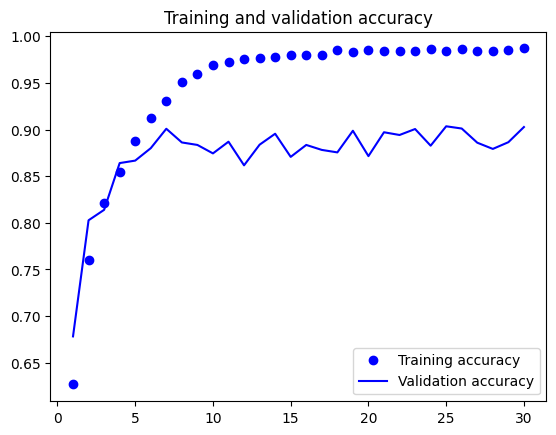

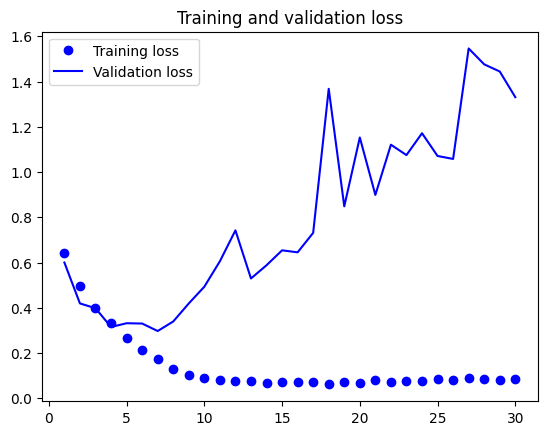

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(model, test_dataset, class_names=["cat", "dog"]):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images, verbose=0)
        # Convert probabilities to binary predictions (threshold = 0.5)
        preds_binary = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds_binary)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (cat as cat): {tn}")
    print(f"False Positives (cat as dog): {fp}")
    print(f"False Negatives (dog as cat): {fn}")
    print(f"True Positives (dog as dog): {tp}")

In [ ]:
 model.save("convnet_from_scratch1.keras")

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9097 - loss: 1.2105
Test accuracy: 0.904


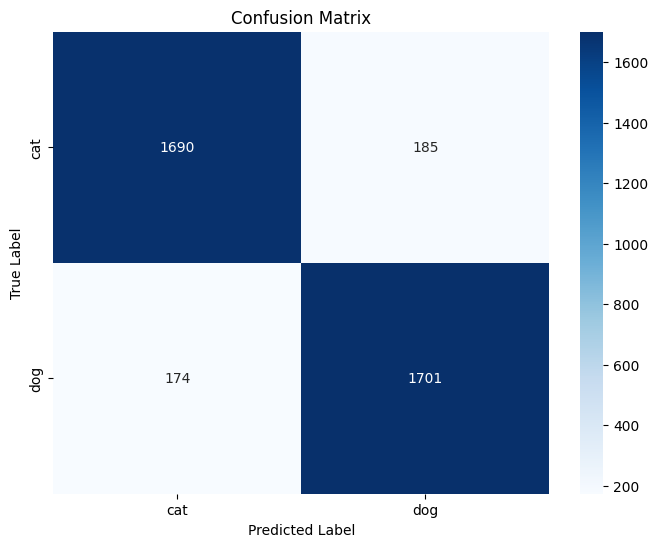

True Negatives (cat as cat): 1690
False Positives (cat as dog): 185
False Negatives (dog as cat): 174
True Positives (dog as dog): 1701


In [ ]:
plot_confusion_matrix(keras.models.load_model("convnet_from_scratch1.keras"), test_dataset)

In [ ]:
def display_predictions(model, test_dataset, class_names=["cat", "dog"], num_images=6):

    images, labels = next(iter(test_dataset))

    # Predict probabilities
    preds = model.predict(images, verbose=0)
    preds_binary = (preds > 0.5).astype(int).flatten()

    # Convert to numpy arrays
    images = images.numpy()
    labels = labels.numpy()

    # Set up the plot
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
        plt.imshow(images[i].astype("uint8"))  # Assuming images are normalized
        actual_label = class_names[labels[i]]
        pred_label = class_names[preds_binary[i]]
        # Set title color: green if correct, red if wrong
        title_color = "green" if actual_label == pred_label else "red"
        plt.title(f"Actual: {actual_label}\nPred: {pred_label}", color=title_color, fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

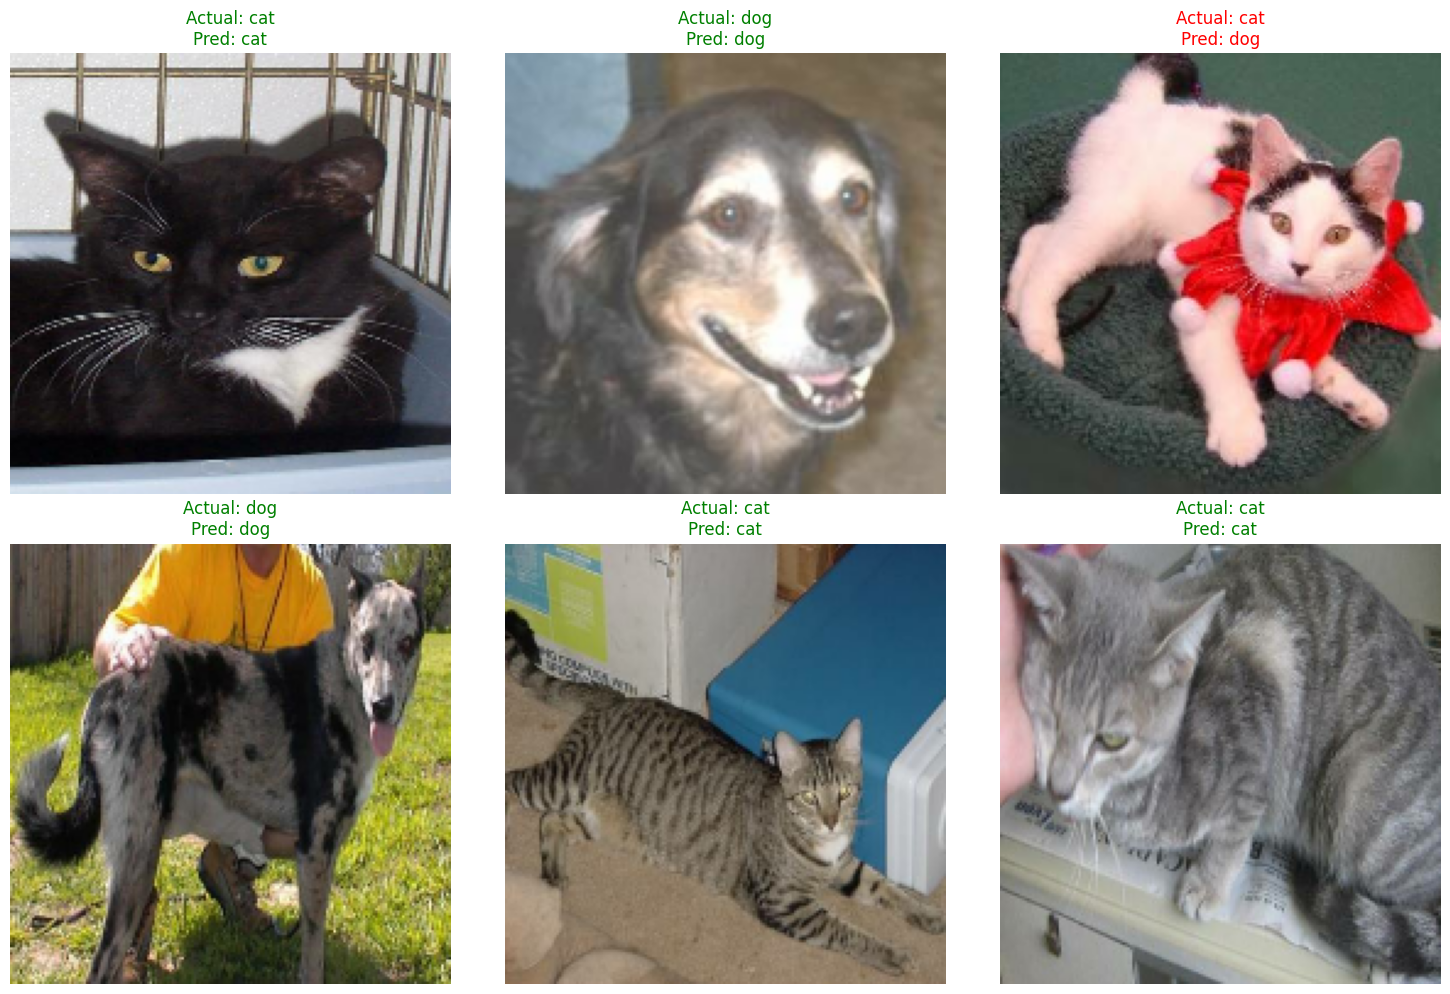

In [ ]:
display_predictions(keras.models.load_model("convnet_from_scratch1.keras"), test_dataset)

## 🧪 Modelltraining mit Data Augmentation – Warum?

In diesem Abschnitt wurde gezielt **Data Augmentation** eingesetzt, um die Generalisierungsfähigkeit des Modells zu verbessern.  
Das Modell erzielte dabei eine **Testgenauigkeit von 95,5 %**.

---

### 📷 Was bedeutet Data Augmentation?

Data Augmentation beschreibt die künstliche Erweiterung des Trainingsdatensatzes durch zufällige Bildtransformationen wie:

- horizontales Spiegeln
- leichte Drehungen
- Zoom-Effekte

Diese Veränderungen werden während des Trainings automatisch auf die Bilder angewendet, ohne die Originaldaten zu verändern. Ziel ist es, das Modell robuster gegenüber Lageveränderungen und Bildvariationen zu machen.

---

### 🧩 Warum wurde Augmentation hier verwendet?

Der ursprüngliche Datensatz besteht zwar aus 25.000 Bildern, jedoch ist er visuell relativ einheitlich. Ohne Augmentation besteht die Gefahr, dass das Modell die Trainingsdaten zu genau „auswendig lernt“ – ein Effekt, der als **Overfitting** bezeichnet wird.  
Mit Hilfe von Augmentation wird die Datenvielfalt erhöht, wodurch das Modell **nicht auf spezifische Bildpositionen oder -muster angewiesen** ist, sondern allgemeine Merkmale lernt.

---

### 🕒 Warum 100 Epochen?

Durch den Einsatz von Augmentation in Kombination mit Regularisierung (z. B. Dropout und Batch Normalization) wird Overfitting deutlich reduziert.  
Daher kann das Modell **über einen längeren Zeitraum trainiert werden**, ohne dass die Validierungsgenauigkeit sofort absinkt.  
Die Wahl von **100 Epochen** ermöglicht es dem Modell, diese zusätzlichen, künstlich erzeugten Trainingsbeispiele effektiv zu nutzen und dadurch bessere Ergebnisse auf unbekannten Daten zu erzielen.


In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ])

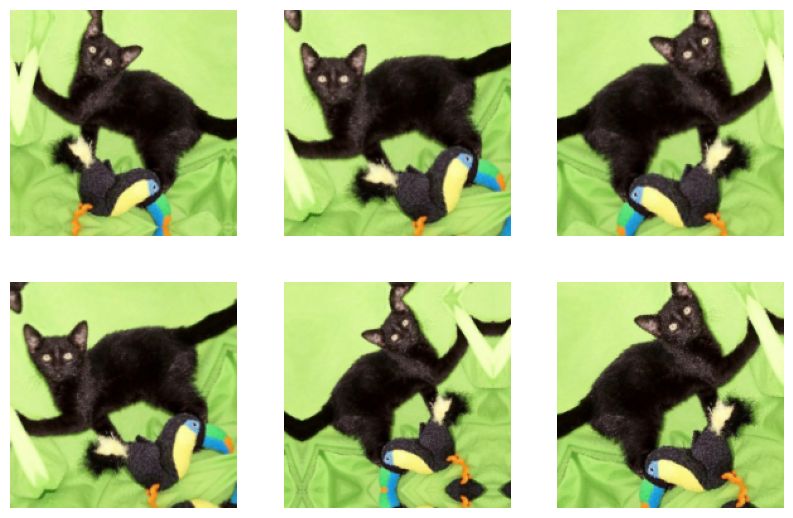

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(6):
       augmented_images = data_augmentation(images)
       ax = plt.subplot(3, 3, i + 1)
       plt.imshow(augmented_images[0].numpy().astype("uint8"))
       plt.axis("off")

In [ ]:
# Define the model with regularization
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Conv Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x) # Dropout

# Conv Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

# Conv Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

# Conv Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

# Conv Block 5
x = layers.Conv2D(filters=256, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model2.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
     monitor="val_loss")
  ]

In [ ]:
history = model2.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 110ms/step - accuracy: 0.5617 - loss: 1.0837 - val_accuracy: 0.6360 - val_loss: 0.7088
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.6450 - loss: 0.7391 - val_accuracy: 0.6597 - val_loss: 0.6375
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step - accuracy: 0.6858 - loss: 0.6350 - val_accuracy: 0.7027 - val_loss: 0.6446
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.7224 - loss: 0.5656 - val_accuracy: 0.6603 - val_loss: 0.6195
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.7516 - loss: 0.5117 - val_accuracy: 0.7715 - val_loss: 0.4909
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - accuracy: 0.7675 - loss: 0.4854 - val_accuracy: 0.7707 - val_loss: 0.4971
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.7814 - loss: 0.4592 - val_accuracy: 0.8067 - val_loss: 0.4151
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.7981 -

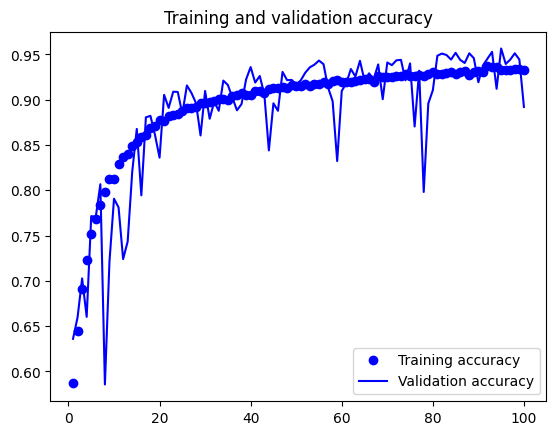

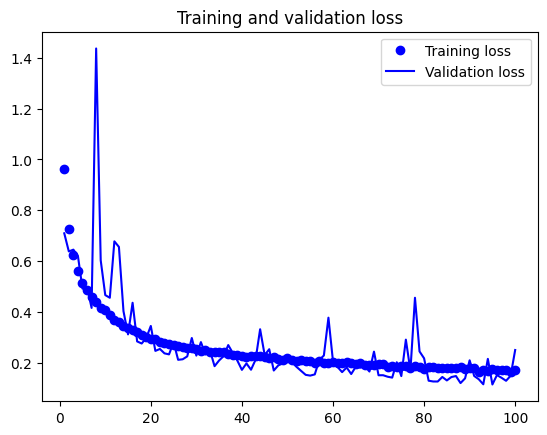

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9556 - loss: 0.1180
Test accuracy: 0.955


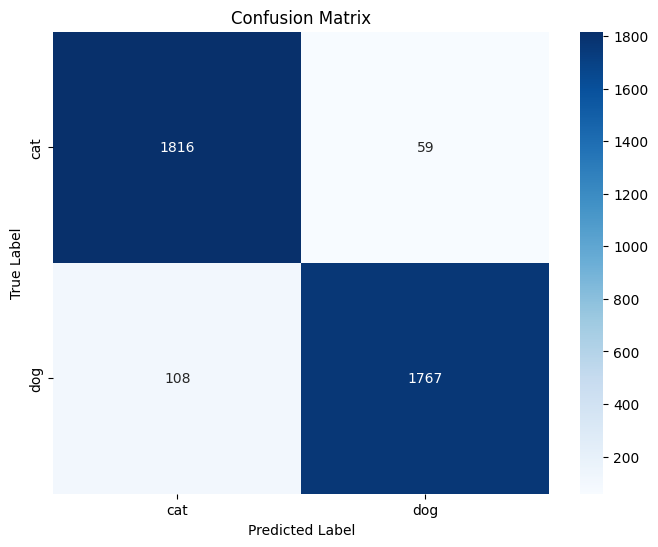

True Negatives (cat as cat): 1816
False Positives (cat as dog): 59
False Negatives (dog as cat): 108
True Positives (dog as dog): 1767


In [ ]:
plot_confusion_matrix(keras.models.load_model("convnet_from_scratch_with_augmentation.keras"), test_dataset)

## 🔁 Transfer Learning mit VGG16 (Feature Extraction)

In diesem Teil wurde **Transfer Learning** mithilfe des vortrainierten VGG16-Modells eingesetzt.  
Das Ziel ist es, bereits erlernte Merkmale aus einem großen Datensatz (ImageNet) wiederzuverwenden, um auf dem aktuellen Datensatz (Hunde vs. Katzen) effizient zu lernen.

---

### 🔍 Vorgehen:

- Das VGG16-Modell wurde über `keras.applications.vgg16.VGG16()` eingebunden.
- Die Option `include_top=False` entfernt die ursprüngliche Klassifikationsschicht, sodass nur die Faltungsblöcke erhalten bleiben.
- `weights="imagenet"` lädt die vortrainierten Gewichte.
- `trainable = False`: Die Gewichte des VGG16-Modells werden eingefroren, d. h. sie werden **nicht verändert** während des Trainings. Das Modell dient also nur zur **Merkmalextraktion**.

---

### 🔄 Architektur (angepasst)

Auf das ausgegebene Feature-Volume von VGG16 folgen:

- `Flatten()` – Umwandlung in einen Vektor
- `Dense(256)` – voll verbundene Schicht mit 256 Neuronen
- `Dropout(0.5)` – zur Reduktion von Overfitting
- `Dense(1, activation="sigmoid")` – binäre Klassifikation

---

### ⚙️ Training

- Optimizer: `rmsprop`
- Loss: `binary_crossentropy`
- Epochen: 30
- Validierungsstrategie: `ModelCheckpoint` speichert das Modell mit dem besten Validierungsverlust

---

### 📈 Ergebnisse

- Das Modell erreichte nach dem Training eine **Testgenauigkeit von 97,6 %** (`val_accuracy` teilweise > 98 %).
- Die Kombination aus vortrainiertem Merkmalsextraktor, Dropout und Data Augmentation führt zu einer sehr guten Generalisierung.
- Trotz leicht schwankendem Validierungsverlust bleibt die Genauigkeit stabil, was auf ein **robustes Modell** mit guter Feature-Grundlage hindeutet.

---

### 💡 Fazit

Transfer Learning bietet eine effiziente Möglichkeit, mit vergleichsweise wenig Rechenaufwand hohe Ergebnisse zu erzielen, insbesondere wenn die zugrunde liegenden Merkmale (wie bei Bildern von Tieren) stark den vortrainierten Daten ähneln.


In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))


conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model3 = keras.Model(inputs, outputs)

In [ ]:
model3.compile(loss="binary_crossentropy",
      optimizer="rmsprop",
      metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
 ]

In [ ]:
history = model3.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - accuracy: 0.9530 - loss: 1.1117 - val_accuracy: 0.9768 - val_loss: 0.3790
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 0.9581 - loss: 0.6531 - val_accuracy: 0.9584 - val_loss: 0.7677
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - accuracy: 0.9563 - loss: 0.6912 - val_accuracy: 0.9781 - val_loss: 0.3615
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 73s 133ms/step - accuracy: 0.9596 - loss: 0.7019 - val_accuracy: 0.9816 - val_loss: 0.3569
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.9643 - loss: 0.6250 - val_accuracy: 0.9773 - val_loss: 0.5255
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9624 - loss: 0.7776 - val_accuracy: 0.9736 - val_loss: 0.6747
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 131ms/step - accuracy: 0.9653 - loss: 0.7309 - val_accuracy: 0.9763 - val_loss: 0.5550
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.9650 - loss: 0

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9745 - loss: 0.5933
Test accuracy: 0.976


## 🔧 Fine-Tuning – Was ist das und wie wird es eingesetzt?

**Fine-Tuning** ist eine Methode des Transfer Learning, bei der ein vortrainiertes Modell weiter angepasst (also „feinjustiert“) wird, um es optimal auf eine neue, spezifische Aufgabe abzustimmen.

In unserem Projekt haben wir zunächst das **VGG16-Modell**, das ursprünglich auf dem ImageNet-Datensatz trainiert wurde, als Feature-Extractor verwendet. Dabei wurden alle Schichten des Modells eingefroren, sodass nur der neu hinzugefügte Klassifikationskopf trainiert wurde.

📌 **Beim Fine-Tuning** gehen wir einen Schritt weiter:
- Wir **frieren nur die unteren (allgemeineren) Schichten** des Modells ein.
- Die **oberen (spezialisierteren) Schichten werden freigegeben**, um sie mit unseren Hund/Katze-Bildern neu zu trainieren.
- Dadurch kann das Modell spezifische Merkmale unserer Bilder besser lernen, ohne bereits erlerntes Wissen vollständig zu überschreiben.

### ✅ Vorteile des Fine-Tuning:
- Erhöhte Genauigkeit durch bessere Anpassung an den Ziel-Datensatz
- Nutzung bereits vorhandener Bildmerkmale (Edges, Muster etc.)
- Geringerer Rechenaufwand im Vergleich zu komplettem Training von Grund auf

In unserem Fall konnte durch Fine-Tuning eine Testgenauigkeit von **98,2 %** erreicht werden – ein deutlicher Leistungsgewinn gegenüber dem Basismodell.



In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-8]:
    layer.trainable = False

In [ ]:
model3.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
      metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
 ]

In [ ]:
history = model3.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 114s 202ms/step - accuracy: 0.9609 - loss: 0.9288 - val_accuracy: 0.9717 - val_loss: 0.2174
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 130s 183ms/step - accuracy: 0.9616 - loss: 0.1828 - val_accuracy: 0.9789 - val_loss: 0.0993
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 110s 202ms/step - accuracy: 0.9689 - loss: 0.0980 - val_accuracy: 0.9789 - val_loss: 0.0895
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 110s 200ms/step - accuracy: 0.9784 - loss: 0.0805 - val_accuracy: 0.9803 - val_loss: 0.0944
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 201ms/step - accuracy: 0.9788 - loss: 0.0674 - val_accuracy: 0.9843 - val_loss: 0.0672
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 109s 200ms/step - accuracy: 0.9829 - loss: 0.0571 - val_accuracy: 0.9861 - val_loss: 0.0758
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 100s 182ms/step - accuracy: 0.9862 - loss: 0.0433 - val_accuracy: 0.9883 - val_loss: 0.0915
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 151s 199ms/step - accuracy: 0.9877 -

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9791 - loss: 0.0854
Test accuracy: 0.982


## 🧾 Fazit

Im Rahmen dieses Projekts wurde ein Bildklassifikationsmodell zur Unterscheidung von Hunden und Katzen entwickelt. Ziel war es, verschiedene Modellierungsstrategien zu testen und die Performance systematisch zu verbessern.

### 📌 Zusammenfassung der Ansätze:

1. **Baseline-CNN (Modell 1):**
   - Eigenes CNN-Modell ohne Data Augmentation
   - Testgenauigkeit: **~90.4 %**

2. **CNN mit Data Augmentation und Regularisierung (Modell 2):**
   - Erweiterung um Techniken wie `Dropout`, `BatchNormalization` und `RandomFlip/Zoom`
   - Testgenauigkeit: **~95.5 %**

3. **Transfer Learning mit VGG16 (Modell 3):**
   - Verwendung eines vortrainierten VGG16-Modells (Feature Extraction)
   - Testgenauigkeit: **~97.6 %**

4. **Fine-Tuning auf VGG16 (Modell 4):**
   - Teilweise Freigabe der oberen Schichten zur Nachjustierung der Gewichte
   - Testgenauigkeit: **~98.2 %**

### 🎯 Erkenntnisse:

- **Data Augmentation** hat signifikant zur Vermeidung von Overfitting beigetragen und die Robustheit des Modells verbessert.
- **Transfer Learning** ermöglicht eine deutliche Performance-Steigerung – insbesondere wenn nur eine begrenzte Anzahl an Trainingsdaten verfügbar ist, und perfomantere Trainingszeit.
- **Fine-Tuning** ist ein wirkungsvolles Mittel zur weiteren Optimierung eines Modells, das bereits auf einem ähnlichen Anwendungsfall trainiert wurde.
- Die Kombination aus bewährten Architekturansätzen und gezielter Anpassung auf den Datensatz erwies sich als besonders effektiv.

---

### ✅ Fazit in einem Satz:
Mit Hilfe verschiedener Deep-Learning-Strategien konnte ein robustes Modell entwickelt werden, das Hunde und Katzen mit einer Genauigkeit von **bis zu 98,2 %** korrekt klassifiziert.
